In [24]:
from scipy.linalg import inv, toeplitz
import numpy as np
from numpy.random import uniform, multivariate_normal, randn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Échantillonneur de Gibbs

In [2]:
# Fonction retournant les paramètres a posteriori de x|y pour
# x ~ N(x0, Rx)
# y ~ N(Ax0, Rb)

# les matrices en arguments sont les inverses des matrices de covariances

def gaussgauss(y, x0, A, Rxinv, Rbinv):
    
    Rpost = inv(A.T @ Rbinv @ A + Rxinv)
    xpost = Rpost @ (A.T @ Rbinv @ y + Rxinv @ x0)
    
    return xpost, Rpost

In [25]:
# échantilloneur de Gibbs

# xinit, dinit initialisation
# Rx, Rd, Rb matrices de covariances
# A modèle linéaire
# y données
# q à expliquer
# N nombre d'échantillons

def gibbs(xinit, dinit,  Rx, Rd, Rb, A, y, q, N):
    
    xinit = np.zeros(xinit.shape)
    dinit = np.ones(dinit.shape)
    
    Rxinv = inv(Rx)
    Rbinv = inv(Rb)
    Rdinv = inv(Rd)

    X = np.zeros([xinit.shape[0], N])
    D = np.zeros([dinit.shape[0], N])

    X[:, 0] = xinit
    D[:, 0] = dinit
    
    for n in tqdm(range(1, N)):
        
        if uniform() > q:                      
            newx = sample_x(D[:, n-1],Rxinv, Rbinv, A, y)
            
            D[:, n] = D[:, n-1]
            X[:, n] = newx
            
        else:
            newd = sample_d(X[:, n-1],Rdinv, Rbinv, A, y)
            
            D[:, n] = newd
            X[:, n] = X[:, n-1]   
            
    return X, D


# échantillonages selon les lois conditionnelles
# à compléter
# ne pas hésiter à changer les arguments des fonctions

def sample_x(d, Rx, Rb, A, y):

    Ax = np.diag(d) @ A 
    xpost, Rpost = gaussgauss(y,np.zeros(d.shape[0]) , Ax, Rx, Rb) 
    newx = np.random.multivariate_normal(xpost, Rpost);
    return newx

def sample_d(x, Rd, Rb, A, y):
    
    Ad = np.diag(A@x)
    xpost, Rpost = gaussgauss(y, np.ones(x.shape[0]), Ad, Rd, Rb) 
    newd = np.random.multivariate_normal(xpost, Rpost);
    return newd



## Génération des données

In [26]:
L = 30 # dimension

# matrice de covariance de x a priori
r = np.zeros([L])
r[0] = 3
r[1] = 1
Rx = toeplitz(r)

Rb = np.eye(L)
Rd = np.eye(L)/5
A = randn(L, L)

x = multivariate_normal(np.zeros([L]), Rx)
d = multivariate_normal(np.ones([L]), Rd)
b = multivariate_normal(np.zeros([L]), Rb)


y = np.diag(d) @ A @ x + b


# Évaluation

Donner les grandeurs et tracer les courbes que vous jugez nécessaires pour valider la méthode.

On pourra, par exemple, comparer les erreurs d'estimation entre

* méthode de calibration aveugle 
* modèle décalibré (pas de prise en compte de la décalibration)
* modèle calibré (gains $\mathbf d$ connus)

In [28]:
# les résultats de GIBBS 
N = 10_000;
q = 0.5
xinit = np.zeros([L])
dinit = np.zeros([L])
X, D = gibbs(xinit, dinit,  Rx, Rd, Rb, A, y, q, N)

100%|██████████| 9999/9999 [00:03<00:00, 3092.70it/s]


In [31]:
# méthode de calibration aveugle:
d = multivariate_normal(np.ones([L]), Rd)
Ax = np.diag(d) @ A 
xpost, Rpost = gaussgauss(y,np.zeros(d.shape[0]) , Ax, Rx, Rb) 

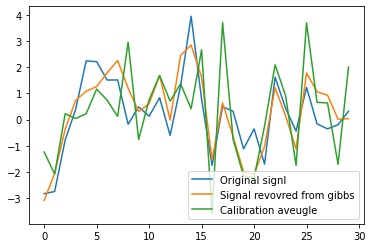

In [34]:
X = np.mean(X, axis=1)
plt.plot(x, label ="Original signl")
plt.plot(X, label="Signal revovred from gibbs")
plt.plot(xpost, label = "Calibration aveugle")
plt.legend()

In [30]:
print(f"The mean squared error for gibbs is { np.mean((X-x)**2)}")

The mean squared error is 0.654872119118771


In [35]:
print(f"The mean squared error for blind calibration is { np.mean((xpost-x)**2)}")

The mean squared error for blind calibration is 2.618316626447919
